# Mini-Project on text mining
# Amazon Reviews for Sentiment Analysis

*Emmanuel Viennet 2019-12-15, 2020-12-02*

Dataset: https://www.kaggle.com/bittlingmayer/amazonreviews


The reviews are short texts (3.6 millions in training, and 400000 in testing), considered either positives (ratings 5 or 4 stars on Amazon) or negatives (1 or 2 stars). Neutral reviews (3 stars) are not included in this dataset.

In [33]:
import numpy as np 
import pandas as pd 
import bz2
import gc
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

print(os.listdir("data"))
# To run on your own computer, you should download and unzip the 
# dataset in a subdirectory names "data"
# see https://www.kaggle.com/bittlingmayer/amazonreviews
# => ['test.ft.txt.bz2', 'train.ft.txt.bz2']

['test.ft.txt.bz2', 'train.ft.txt.bz2']


## Read and preprocess data

In [2]:
train_file = bz2.BZ2File('data/train.ft.txt.bz2')
test_file = bz2.BZ2File('data/test.ft.txt.bz2')

### Create Lists containing Train & Test sentences

In [3]:
# Can take some time (20'' ... 2' depending on your hardware)
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()
# save memory
del train_file, test_file
gc.collect()

42

In [4]:
len(train_file_lines), len(test_file_lines)

(3600000, 400000)

In [5]:
train_file_lines[0]

b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

### Convert from raw binary strings to strings that can be parsed
The previous cell shows that the data is in "binary" strings (byte sequences). In Python, it is easier to handle strings, represented as Unicode object (where a character may be coded as several bytes). The `decode` method build unicode strings from binary data, the argument specifies the encoding of the data bytes (here we know that our dataset is using UTF-8).

In [6]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [7]:
train_labels = np.array([0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines])
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
    
test_labels = np.array([0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines])
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file_lines]

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])
                                                       
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

**A negative example** a review associated to the class 0:

In [8]:
train_sentences[10], train_labels[10]

("the worst!: a complete waste of time. typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. i'm embarrassed for this author and very disappointed i actually paid for this book.",
 0)

**A positive example**

In [9]:
train_sentences[8], train_labels[8]

("a five star book: i just finished reading whisper of the wicked saints. i fell in love with the caracters. i expected an average romance read, but instead i found one of my favorite books of all time. just when i thought i could predict the outcome i was shocked ! the writting was so descriptive that my heart broke when julia's did and i felt as if i was there with them instead of just a distant reader. if you are a lover of romance novels then this is a must read. don't let the cover fool you this book is spectacular!",
 1)

In [10]:
print('Training set')
print(f'{np.count_nonzero( train_labels == 0 )} in class 0')
print(f'{np.count_nonzero( train_labels == 1 )} in class 1')

Training set
1800000 in class 0
1800000 in class 1


# Questions

1. Frequency analysis: what are the most frequent words in the reviews ?
2. Apply standard NLP process (see lecture and https://www.kaggle.com/kanncaa1/applying-text-mining) and vectorize the text reviews.
3. Build Naive Bayes, Linear Support Vector Machine and other models to predict the labels (positive/negatives). Discuss the results.
4. Encode the text using a pretrained neural network (embedding). Can you build a better classifier ?


## 1. Frequency analysis: what are the most frequent words in the reviews ?

In [29]:
%%time
#We will use a dictionary to count the number of appearences of the words :)
words = {}
for i in range(len(train_sentences)):
    for j in train_sentences[i].split():
        if j in words.keys():
            words[j] += 1
        else:
            words[j] = 1

Wall time: 2min


In [30]:
df_train = pd.DataFrame(list(zip(words.keys(), words.values())), columns =['Word', 'Count'])

In [31]:
df_train.sort_values(by="Count",ascending=False).head(30)

,Word,Count
3,the,14037613
45,and,7555656
18,i,7202082
47,a,7139490
21,to,6851962
34,of,5628214
5,this,5031158
68,is,4876303
10,it,4762160
13,in,3219443


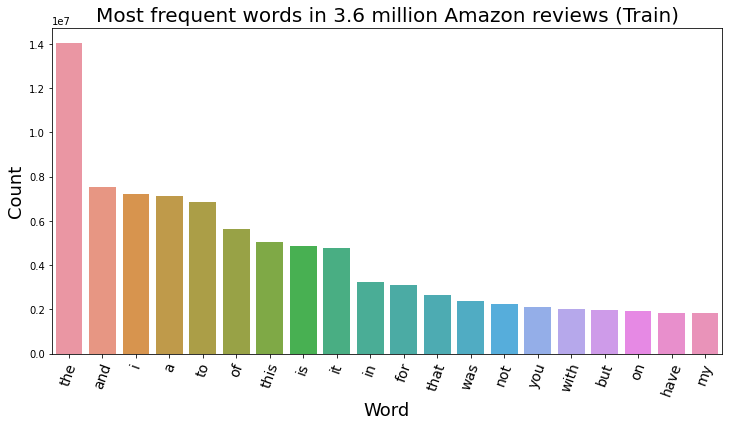

In [54]:
plt.rcParams["figure.figsize"] = (12,6)
sns.barplot(x="Word", y="Count", data=df_train.sort_values(by="Count",ascending=False).head(20))
plt.xticks(fontsize=14, rotation=70)
plt.xlabel("Word",fontsize=18)
plt.ylabel("Count", fontsize = 18)
plt.title("Most frequent words in 3.6 million Amazon reviews (Train)", fontsize=20);

In [51]:
%%time
#We will use a dictionary to count the number of appearences of the words :)
words_test = {}
for i in range(len(test_sentences)):
    for j in test_sentences[i].split():
        if j in words_test.keys():
            words_test[j] += 1
        else:
            words_test[j] = 1

Wall time: 13.5 s


In [52]:
df_test = pd.DataFrame(list(zip(words_test.keys(), words_test.values())), columns =['Word', 'Count'])

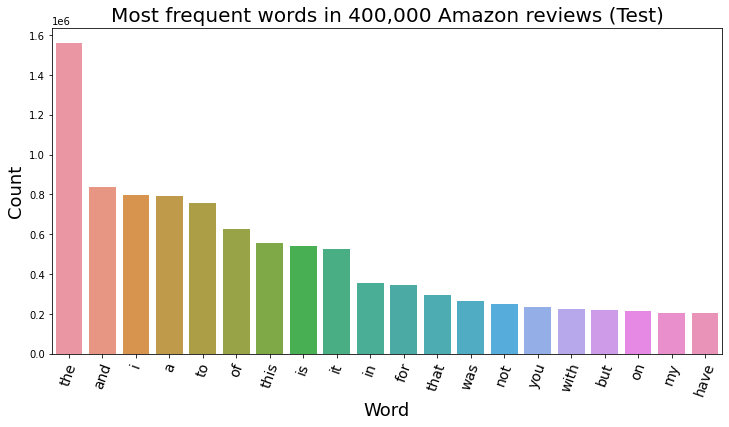

In [55]:
plt.rcParams["figure.figsize"] = (12,6)
sns.barplot(x="Word", y="Count", data=df_test.sort_values(by="Count",ascending=False).head(20))
plt.xticks(fontsize=14, rotation=70)
plt.xlabel("Word",fontsize=18)
plt.ylabel("Count", fontsize = 18)
plt.title("Most frequent words in 400,000 Amazon reviews (Test)", fontsize=20);

## 2. Apply standard NLP process and vectorize the text reviews.

In [62]:
import nltk as nlp
nlp.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [ ]:
%%time
# lemmatization
lemma_train_sentences = []

lemma = nlp.WordNetLemmatizer()
for i in range(len(train_sentences)):
    lemma_sentence = []
    for j in train_sentences[i].split():
        lemma_sentence.append(lemma.lemmatize(j))
    lemma_train_sentences.append(lemma_sentence)

In [ ]:
lemma_train_sentences[0]